# Prediction with a Pre-trained PU-Net 



This notebook documents a comprehensive workflow for full image prediction on microtubule specimens using a pre-trained Projection Upsampling Network (PU-Net). The procedure involves loading experimental imaging data, executing the network's prediction algorithm to reconstruct high-resolution structural details, and performing a comparative analysis against established ground truth data. The following sections describe data preprocessing, model inference, and the visualization of raw input, network output, and grond truth.

In [9]:
# %%
import datetime
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict
from projection_upsampling_network.projection_upsampling_class import ProjectionUpsamplingConfig, ProjectionUpsampling
import tensorflow as tf
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse, structural_similarity as ssim, normalized_root_mse as nrmse_sklearn
import csv
import datetime
from csbdeep.utils import normalize
import mrcfile
from skimage.transform import resize
import os
import tifffile 

### Configure Variable Paths
- Note: Images from the BioSR dataset in .mrc format are loaded directly. 
- TIFF files require conversion and appropriate transposition to meet the network's input shape.

In [12]:

root_dir = './dataset/microtubules'
model_dir = '../trained_model/' 

input_data = f'{root_dir}/test/Cell_001/RawSIMData_level_03.mrc'
gt_data = f'{root_dir}/test/Cell_001/SIM_gt.mrc'

Input data shape: (9, 502, 502)
Ground truth data shape: (1004, 1004)


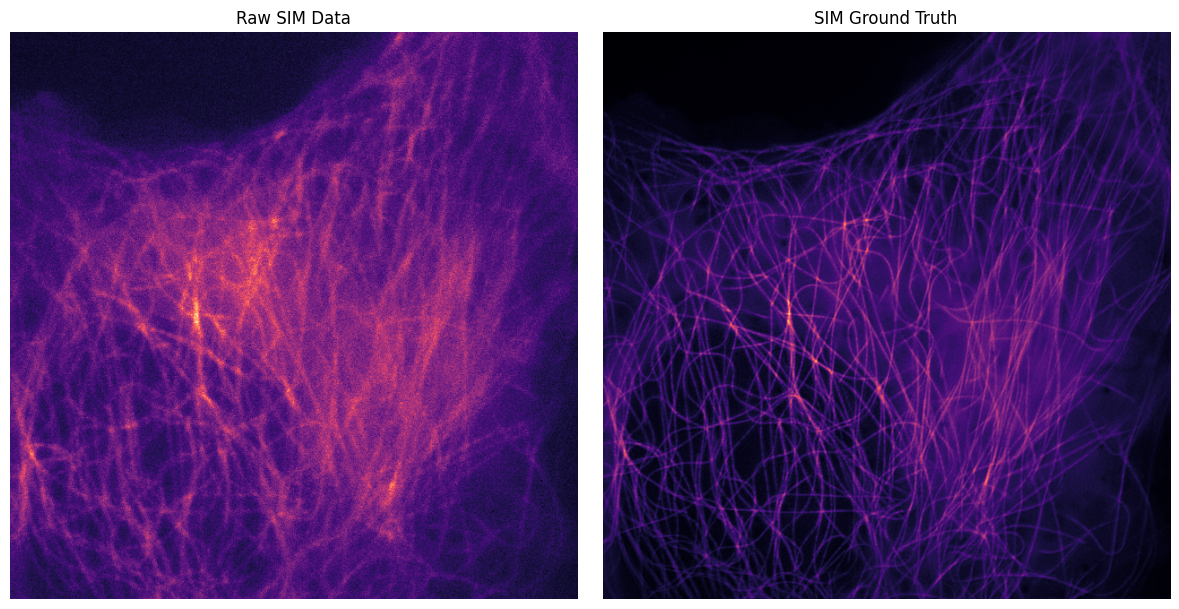

In [13]:
# input_data = tifffile.imread(input_data)
# gt_data = tifffile.imread(gt_data)



with mrcfile.open(input_data, mode='r', permissive = True) as mrc:
    input_data = mrc.data

with mrcfile.open(gt_data, mode='r', permissive = True) as mrc:
    gt_data = mrc.data

    
print(f'Input data shape: {input_data.shape}')
print(f'Ground truth data shape: {gt_data.shape}')




### lets display the images die by side and have a look 

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# tarnspose the data to 502,502,9 as matplotlib expected shape. and display onle the first frame
axes[0].imshow(input_data.transpose(1,2,0)[...,1], cmap='magma')
axes[0].set_title('Raw SIM Data')
axes[0].axis('off')
axes[1].imshow(gt_data, cmap='magma')
axes[1].set_title('SIM Ground Truth')
axes[1].axis('off')
plt.tight_layout()
plt.show()

### Load the model and prediction
- we are using a pre-trained model here
- config file set to None as the model folder already has its config file and loads from there. 
- the model load the model weight from th model folder. 


In [14]:
model = ProjectionUpsampling(
            config=None,
            name='microtubules_pre_trained',
            basedir=model_dir)
print(f'model_dir : {model_dir}')
model.load_weights('weights_best.h5')

shape of input: (None, None, None, None, 1)
Loading network weights from 'weights_best.h5'.
model_dir : ../trained_model/


In [ ]:
 # add a dummy dimension
input_data = input_data[:,:,:,np.newaxis]

# the model expects a input shape of depth:(9), hight:(502), width:(502), channel:(1). 
prediction = model.predict(normalize(input_data), axes = 'ZYXC')

### Vsualization

(1006, 1006, 1)


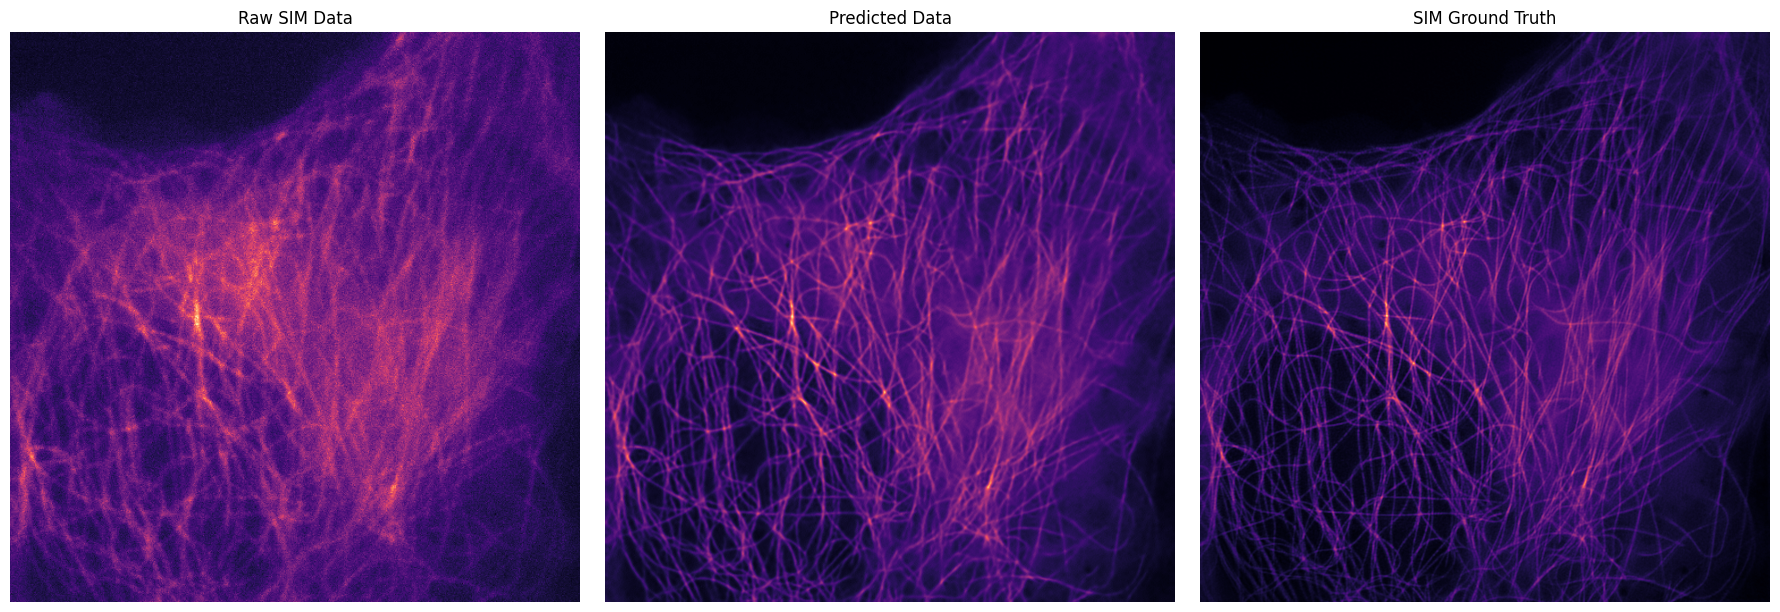

In [ ]:
# notice that the expected shape of the full image is 1004,1004, hoewever the input data is 1006,1006. 
# this extra pixel come from the network prediction on full image as the features are getting upsamples along the axis. 
# to mitigate the problem, we use a resizer. 

print(prediction.shape)
prediction = resize(prediction, (1004, 1004,1), anti_aliasing=True)


# Create 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Prepare input data: remove the extra dimension
raw_input = np.squeeze(input_data)  # shape becomes (Z, Y, X)
slice_index = 1 if raw_input.shape[0] > 1 else 0
axes[0].imshow(raw_input[slice_index], cmap='magma')
axes[0].set_title('Raw SIM Data')
axes[0].axis('off')

# Plot predicted data (squeeze if necessary)
axes[1].imshow(np.squeeze(prediction), cmap='magma')
axes[1].set_title('Predicted Data')
axes[1].axis('off')

# Plot ground truth data
axes[2].imshow(gt_data, cmap='magma')
axes[2].set_title('SIM Ground Truth')
axes[2].axis('off')

plt.tight_layout()
plt.show()
